In [1]:
import os, torch

from pytorch_lightning import Trainer

from kymjtfs.cnn import MedleySolosClassifier, MedleyDataModule, MedleySolosDB


In [17]:
from kymjtfs.cnn import LeNet
import librosa, torch
import torch.nn.functional as F
import numpy as np

net = LeNet(num_classes=8, in_channels=1)
x = torch.randn((1, 2**16))
cqt = np.log1p(np.abs(librosa.cqt(x.numpy(), sr=44100, n_bins=96, hop_length=256)))
F.avg_pool2d(torch.tensor(cqt), kernel_size=(3, 8)).shape

torch.Size([1, 32, 32])

### Load from checkpoint

In [2]:
ckpt = '/homes/cv300/Documents/scattering/lightning_logs/version_15/checkpoints/epoch=9-step=14599.ckpt'
model = MedleySolosClassifier.load_from_checkpoint(ckpt)
model.eval()
model = model.cuda()

In [3]:
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader

test_loader = MedleySolosDB(subset='test')
test_ds = DataLoader(test_loader, batch_size=4, num_workers=80)

trainer = Trainer(gpus=-1, progress_bar_refresh_rate=1)
trainer.test(model, test_dataloaders=test_ds)

/homes/cv300/venvs/dafx/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/homes/cv300/venvs/dafx/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:906: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.0,
 'test/acc_epoch': 0.0,
 'test/loss': 2.779566764831543,
 'test/loss_epoch': 2.779566764831543}
--------------------------------------------------------------------------------


[{'test/loss': 2.779566764831543,
  'test/loss_epoch': 2.779566764831543,
  'test/acc': 0.0,
  'test/acc_epoch': 0.0}]

In [15]:
import random
from IPython.display import Audio 

last_idx = len(test_loader.df) 
idx = random.randint(0, last_idx)
item = test_loader.df.iloc[idx]
print(item['instrument_id'], item['instrument'], item['index'])

audio, y = test_loader.__getitem__(idx)
Audio(audio, rate=22050, autoplay=True)

2 female singer 2308


In [16]:
y_pred = model(audio)

In [17]:
torch.argmax(y_pred)

tensor(7, device='cuda:0')

In [3]:
import pandas as pd
import os
path = '/import/c4dm-datasets/medley-solos-db/'
df = pd.read_csv(os.path.join(path, 'annotation/Medley-solos-DB_metadata.csv'))

### Histogram of magnitudes

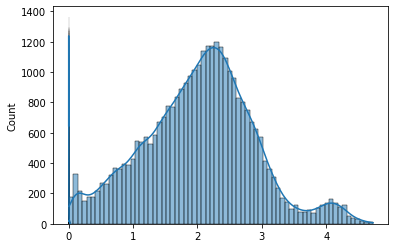

In [132]:
import os, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

jtfs_dir = '/import/c4dm-datasets/medley-solos-db/jtfs/'
train = os.path.join(jtfs_dir, 'training')
stats = os.path.join(jtfs_dir, 'stats')

mu = np.load(os.path.join(stats, 'mu.npy'))

files = [os.path.join(train, f) for f in os.listdir(train) if 'S2' in f]
s2 = np.concatenate([np.load(f) for f in files[0:1000]])
s2 = s2.mean(axis=-2)

idx = 50

mu_idx = mu[idx + 1]
sns.histplot(s2[:, idx, :].flatten(), bins='auto', kde=True)
ax = sns.histplot(np.log1p(s2[:, idx, :].flatten() / (1e-1 * mu_idx)), bins='auto', kde=True)